In [155]:
import numpy as np
import matplotlib.pylab as plt

In [156]:
import crocoddyl

In [157]:
from IPython.display import HTML
import matplotlib.pyplot as plt

In [158]:
class DifferentialActionModelLuxo(crocoddyl.DifferentialActionModelAbstract):
    def __init__(self):
        crocoddyl.DifferentialActionModelAbstract.__init__(self, crocoddyl.StateVector(4), 1, 5)  # nu = 1; nr = 6
        self.unone = np.zeros(self.nu)

        self.Jb = 1e-4
        self.Jr = 2.4e-5
        self.inertia_per_theta = 1e-6
        self.costWeights = [100, 1, 1, 1, 1e-3] # phi, theta, wphi, wtheta, f

    def calc(self, data, x, u=None):
        if u is None: u = model.unone
        # Getting the state and control variables
        phi, theta, wphi, wtheta = (x[0]), (x[1]), (x[2]), (x[3])
        f = (u[0])
        Jb_effective = self.Jb + self.inertia_per_theta * theta * theta
        data.xout = np.matrix([1/Jb_effective * f, 1/self.Jr * f]).T

        # Computing the cost residual and value
        data.r = np.matrix(self.costWeights * np.array([phi, theta, wphi, wtheta, f])).T
        data.cost = .5 * (sum(np.asarray(data.r)**2)).item()
#         print(x, data.xout, data.r, data.cost)

In [159]:
luxoDAM = DifferentialActionModelLuxo()
luxoData = luxoDAM.createData()
luxoDAM = model = DifferentialActionModelLuxo()
luxoND = crocoddyl.DifferentialActionModelNumDiff(luxoDAM, True)

In [160]:
# Getting the IAM using the simpletic Euler rule
timeStep = 5e-2
luxoIAM = crocoddyl.IntegratedActionModelEuler(luxoND, timeStep)

In [161]:
# Creating the shooting problem
x0 = np.array([np.pi/2, 0, 0., 0.])
print(x0)
T = 40

[1.57079633 0.         0.         0.        ]


In [162]:
terminalLuxo = DifferentialActionModelLuxo()
terminalLuxoDAM = crocoddyl.DifferentialActionModelNumDiff(terminalLuxo, True)
terminalLuxoIAM = crocoddyl.IntegratedActionModelEuler(terminalLuxoDAM)

terminalLuxo.costWeights[0] = 100
terminalLuxo.costWeights[1] = 1
terminalLuxo.costWeights[2] = 1
terminalLuxo.costWeights[3] = 1
terminalLuxo.costWeights[4] = 1e-3
problem = crocoddyl.ShootingProblem(x0, [luxoIAM] * T, terminalLuxoIAM)

In [163]:
# Solving it using DDP
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackVerbose()])
ddp.solve([], [], 300)

False

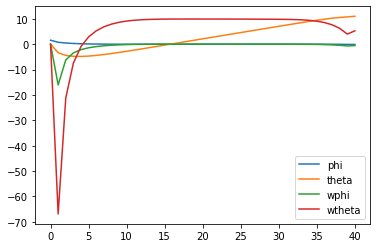

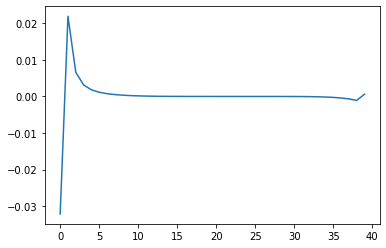

In [164]:
plt.plot(np.array(ddp.xs), label=['phi','theta','wphi','wtheta'])
plt.legend()
plt.figure()
plt.plot(np.array(ddp.us))